In [1]:
# import 
import sys,os,glob
sys.path.append(os.path.abspath('CommonTools'))
import tifffile
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm_notebook as tqdm
import MaxViewer_py3 as mv
import pickle

In [244]:
### Load a single field of view and explore with the max_viewer

folder = r'D:\Data\wea_RCA_test'
folders = glob.glob(folder+'\H*')
folders = [fld for fld in folders if len(glob.glob(fld+r'\*.tif')) and ('_' not in os.path.basename(fld) or 'H1_high' in os.path.basename(fld))]
fovs = [os.path.basename(fl) for fl in glob.glob(folders[0]+r'\*.tif')]
fov = fovs[2] # the field of view to load
cols = ['750','647','405']
ims,ims_nms = [],[]
for fld in tqdm(folders):
    fl = fld+os.sep+fov
    im = tifffile.imread(fl)
    ncols = len(cols)
    for icol,col in enumerate(cols):
        ims.append(im[icol::ncols])
        tag = os.path.basename(os.path.dirname(fl))+'_'+col
        ims_nms.append(tag)

<ipython-input-244-bc63118ea06d>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):


In [245]:
%matplotlib notebook

<IPython.core.display.Javascript object>


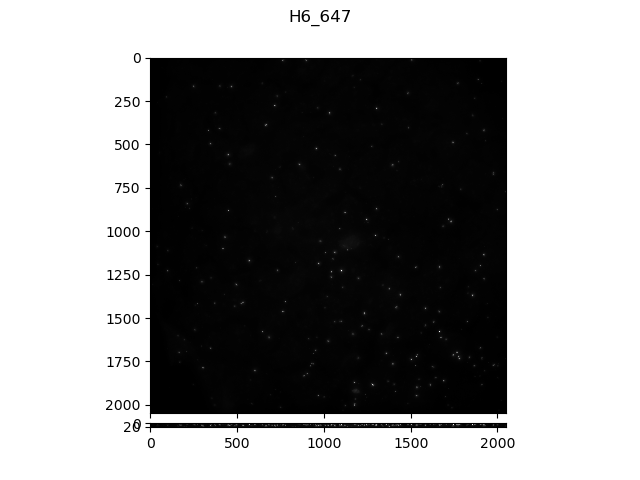

In [246]:
obj = mv.imshow_mark_3d(ims,image_names=ims_nms)

### Define useful functions for main analysis

In [2]:
#Useful functions

from sklearn.cluster import DBSCAN
def get_local_max(im_dif,th_fit,delta=2,dbscan=True):
    """Given a 3D image <im_dif> as numpy array, get the local maxima in cube -<delta>_to_<delta> in 3D.
    Optional a dbscan can be used to couple connected pixels with the same local maximum. 
    This is important if saturating the camera values.
    
    Returns: Xh - a list of z,x,y and brightness of the local maxima
    """
    z,x,y = np.nonzero(im_dif>th_fit)
    zmax,xmax,ymax = im_dif.shape
    in_im = im_dif[z,x,y]
    keep = np.ones(len(x))>0
    for d1 in range(-delta,delta+1):
        for d2 in range(-delta,delta+1):
            for d3 in range(-delta,delta+1):
                keep &= (in_im>=im_dif[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])
    z,x,y = z[keep],x[keep],y[keep]
    h = in_im[keep]
    Xh = np.array([z,x,y,h]).T
    if dbscan:
        from sklearn.cluster import DBSCAN
        db = DBSCAN(eps=1, min_samples=1, metric='euclidean')
        X = np.array([z,x,y]).T
        db.fit(X)
        l = db.labels_
        Xh = []
        for l_ in np.unique(l):
            keep = l==l_
            imax = np.argmax(h[keep])
            Xh.append([z[keep][imax],x[keep][imax],y[keep][imax],h[keep][imax]])
        Xh = np.array(Xh)
    return Xh
import AlignmentTools_py3 as at
def series_align(im1,im2,s = 256,gb=30):
    """
    Given 2 3D images <im1> and <im2> this performs a fft based registration. 
    Robustness measures:
    1) Uses local gaussian correction (dividing the images by gaussian blur) with a kernel size <gb> of 30 piexels. 
    (This is to avoid the fft getting confused by global illumination and focusing on the feature at scale <gb>)
    
    2) Will tile the images <im1> and <im2> in s x s little images and compare each one. Will then use the consensus registration
    
    Returns:
    tzxy - the delta z,x and y between the images
    vecs - a list of tzxy for each subimage comparison (see point 2 above) to troubleshoot
    """
    
    sz,sx,sy = im1.shape
    vecs = []
    for ix in range(0,sx-1,s):
        for iy in range(0,sy-1,s):
            vecs.append(at.fft3d_from2d(im1[:,ix:ix+s,iy:iy+s],im2[:,ix:ix+s,iy:iy+s],gb=gb))
    tzxy = np.median(vecs,axis=0)
    #consistency = np.mean(np.abs(vecs-tzxy),axis=0)
    return tzxy,vecs

import cv2

def get_number_cells(im_dapi,min_area=5000,max_area=50000):
    """Given a binary mask with mostly correct segmentation, this estimates the number of cells and their median area.
    Returns: ncells - number of cells
    med_area - median area of each cell base on connected component analysis
    """
    retval, labels, stats, centroids=cv2.connectedComponentsWithStats(np.array(im_dapi,dtype=np.uint8))
    As = stats[:,-1]
    keep = (As>min_area)&(As<max_area)
    med_area = np.median(As[keep])
    ncells = np.sum(im_dapi)/med_area
    return ncells,med_area

In [256]:
%matplotlib inline
plt.ioff() #turn off matplotlib display. Will save to file

### Main analysis

In [259]:
#Iterate trhough fovs - fit and drift correct

folder = r'D:\Data\wea_RCA_test'
analysis_folder = folder+os.sep+'Analysis'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
folders = glob.glob(folder+'\H*')
folders = [fld for fld in folders if len(glob.glob(fld+r'\*.tif')) and ('_' not in os.path.basename(fld) or 'H1_high' in os.path.basename(fld))]
fovs = [os.path.basename(fl) for fl in glob.glob(folders[0]+r'\*.tif')]
cols = ['750','647','405']



#Iterate across FOVs
for fov in fovs:
    #Load images into dictionary im_dic
    ims,ims_nms = [],[]
    for fld in tqdm(folders):
        fl = fld+os.sep+fov
        im = tifffile.imread(fl)
        ncols = len(cols)
        for icol,col in enumerate(cols):
            ims.append(im[icol::ncols])
            tag = os.path.basename(os.path.dirname(fl))+'_'+col
            ims_nms.append(tag)

    im_dic = {nm.replace('_high',''):im for im,nm in zip(ims,ims_nms)}

    #Fit and drift correct
    
    names = list(im_dic.keys())
    H_nocol = np.unique(['_'.join(e.split('_')[:-1]) for e in names])
    #cols = np.unique([e.split('_')[-1]for e in names])
    cols_bits = ['647', '750']
    col_bead = '405'
    dic_drift = {}
    dic_fits = {}
    dic_extra = {}
    #Load fitted data:
    save_fl = save_base+'_final.pkl'
    if os.path.exists(save_fl):
        dic_drift,dic_fits,dic_extra = pickle.load(open(save_fl,'rb'))
    

    save_base = analysis_folder+os.sep+fov.split('.')[0]
    for H in H_nocol:
        #perfor drift correction
        if H not in dic_drift:
            print("Drift correcting "+H+" on fov: "+fov)
            im1 = im_dic[H_nocol[0]+'_'+col_bead] # reference dapi image
            im2 = im_dic[H+'_'+col_bead] #current dapi image
            dic_drift[H]=series_align(im1,im2,s = 256,gb=30) #drift positions using fft
            
        #perform fitting
        for col in cols_bits:
            key = H+'_'+col
            
            if key not in dic_fits:
                print("Fitting "+H+'_'+col+" on fov: "+fov)
                im = im_dic[H+'_'+col] #current image
                std_ = np.std(im)
                hcut = np.median(im)+std_*5
                hmax = np.median(im)+std_*5 #keep 5 std above median - empirically this looked reasonable for the big spots.
                Xh = get_local_max(im,hcut,delta=3)
                dic_fits[H+'_'+col] = Xh


                #save diagnostic plots - image with fits on top
                fig = plt.figure(figsize=(10,10))
                plt.imshow(np.max(im,0),cmap='gray',vmax = hmax)
                plt.plot(Xh[:,2],Xh[:,1],'o',markersize=12,markeredgewidth=1,markeredgecolor='y',markerfacecolor='None')
                save_fig_ = save_base+'_'+H+'_'+col+'_fit.png'
                fig.savefig(save_fig_)
                plt.close('all')
    #get number of cells
    if not dic_extra:
        print("Estimating number of cells based on dapi image on fov: "+fov)
        H=H_nocol[0]
        im2 = im_dic[H+'_'+col_bead]
        im2_ = at.blurnorm2d(np.max(im2,0),300)
        im_dapi = im2_>1.25
        ncells,med_area = get_number_cells(im_dapi,min_area=5000,max_area=50000)
        dic_extra={'no_cells':ncells,'area_per_cell':med_area}

        save_fig_ = save_base+'_'+H+'_'+col+'_dapi.png'
        fig = plt.figure(figsize=(10,10))
        plt.imshow(np.max(im2,0),cmap='gray')
        plt.contour(im_dapi,[0.5],colors=['r'])
        fig.savefig(save_fig_)
        plt.close('all')

    pickle.dump([dic_drift,dic_fits,dic_extra],open(save_fl,'wb'))

<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_00.tif
Fitting H6_647 on fov: Conv_zscan_00.tif
Fitting H6_750 on fov: Conv_zscan_00.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_01.tif
Fitting H6_647 on fov: Conv_zscan_01.tif
Fitting H6_750 on fov: Conv_zscan_01.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_02.tif
Fitting H6_647 on fov: Conv_zscan_02.tif
Fitting H6_750 on fov: Conv_zscan_02.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_03.tif
Fitting H6_647 on fov: Conv_zscan_03.tif
Fitting H6_750 on fov: Conv_zscan_03.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_04.tif
Fitting H6_647 on fov: Conv_zscan_04.tif
Fitting H6_750 on fov: Conv_zscan_04.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_05.tif


C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:167: RuntimeWarning: invalid value encountered in true_divide
  im1_/=np.std(im1_)
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:183: RuntimeWarning: invalid value encountered in greater
  if np.sum(im_cor>0)>0:
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:164: RuntimeWarning: invalid value encountered in true_divide
  im2_/=np.std(im2_)


Fitting H6_647 on fov: Conv_zscan_05.tif
Fitting H6_750 on fov: Conv_zscan_05.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_06.tif
Fitting H6_647 on fov: Conv_zscan_06.tif
Fitting H6_750 on fov: Conv_zscan_06.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_07.tif
Fitting H6_647 on fov: Conv_zscan_07.tif
Fitting H6_750 on fov: Conv_zscan_07.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_08.tif
Fitting H6_647 on fov: Conv_zscan_08.tif
Fitting H6_750 on fov: Conv_zscan_08.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_09.tif
Fitting H6_647 on fov: Conv_zscan_09.tif
Fitting H6_750 on fov: Conv_zscan_09.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_10.tif
Fitting H6_647 on fov: Conv_zscan_10.tif
Fitting H6_750 on fov: Conv_zscan_10.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_11.tif
Fitting H6_647 on fov: Conv_zscan_11.tif
Fitting H6_750 on fov: Conv_zscan_11.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_12.tif
Fitting H6_647 on fov: Conv_zscan_12.tif
Fitting H6_750 on fov: Conv_zscan_12.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_13.tif


C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:164: RuntimeWarning: invalid value encountered in true_divide
  im2_/=np.std(im2_)
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:167: RuntimeWarning: invalid value encountered in true_divide
  im1_/=np.std(im1_)
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:183: RuntimeWarning: invalid value encountered in greater
  if np.sum(im_cor>0)>0:


Fitting H6_647 on fov: Conv_zscan_13.tif
Fitting H6_750 on fov: Conv_zscan_13.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_14.tif
Fitting H6_647 on fov: Conv_zscan_14.tif
Fitting H6_750 on fov: Conv_zscan_14.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_15.tif
Fitting H6_647 on fov: Conv_zscan_15.tif
Fitting H6_750 on fov: Conv_zscan_15.tif


<ipython-input-259-5d9e203342c2>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H6 on fov: Conv_zscan_16.tif
Fitting H6_647 on fov: Conv_zscan_16.tif
Fitting H6_750 on fov: Conv_zscan_16.tif


### Post-analysis

In [260]:
final_fls = glob.glob(r'D:\Data\wea_RCA_test\Analysis\*_final.pkl')


In [265]:
fl = final_fls[1]
dic_drift,dic_fits,dic_extra = pickle.load(open(fl,'rb'))
pairs = [('H1_647','H3_750'),('H1_750','H4_647'),('H2_647','H6_647'),('H2_750','H5_647'),('H3_647','H6_750')]
dic_fits.keys()

dict_keys(['H1_647', 'H1_750', 'H2_647', 'H2_750', 'H3_647', 'H3_750', 'H4_647', 'H4_750', 'H5_647', 'H5_750', 'H6_647', 'H6_750'])

In [269]:
%matplotlib inline
plt.ion()

In [275]:
%matplotlib notebook

<IPython.core.display.Javascript object>


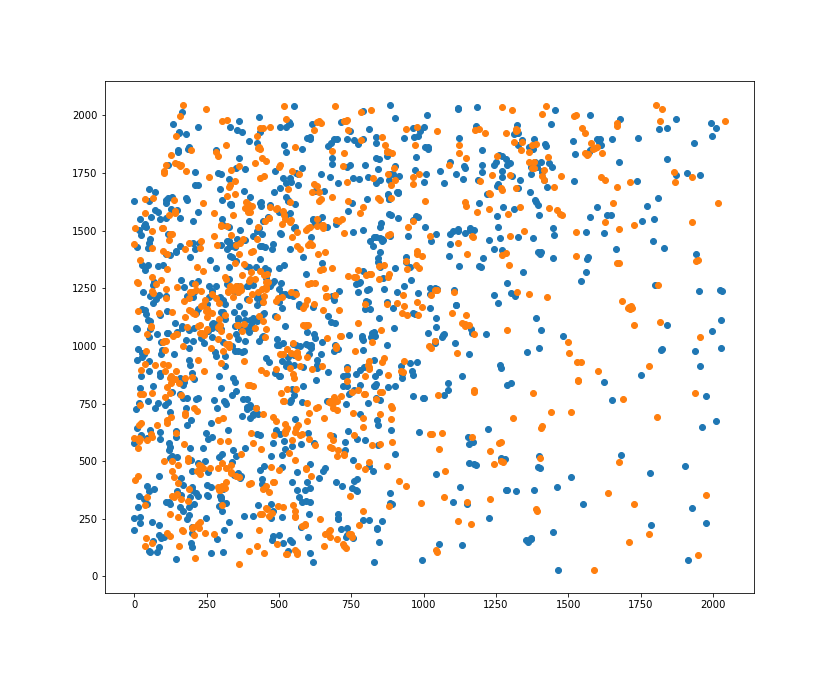

In [278]:
A,B = pairs[3]
z1,x1,y1,h1 =dic_fits[A].T
z2,x2,y2,h2 =dic_fits[B].T
plt.figure()
plt.plot(x1,y1,'o')
plt.plot(x2,y2,'o')

In [3]:
%matplotlib inline

In [17]:
folders = glob.glob(folder+'\H*')
folders = [fld for fld in folders if len(glob.glob(fld+r'\*.tif')) and ('H2' in os.path.basename(fld))]
folders

['D:\\Data\\wea_RCA_test\\H2',
 'D:\\Data\\wea_RCA_test\\H2_high',
 'D:\\Data\\wea_RCA_test\\H2_postCleave',
 'D:\\Data\\wea_RCA_test\\H2_postCleave_high']

['D:\\Data\\wea_RCA_test\\H2',
 'D:\\Data\\wea_RCA_test\\H2_high',
 'D:\\Data\\wea_RCA_test\\H2_postCleave',
 'D:\\Data\\wea_RCA_test\\H2_postCleave_high']

<ipython-input-18-4a79169b8fd3>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):
<ipython-input-18-4a79169b8fd3>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(folders):



Drift correcting H2 on fov: Conv_zscan_02.tif

Drift correcting H2 on fov: Conv_zscan_02.tif
Fitting H2_647 on fov: Conv_zscan_02.tif
Fitting H2_647 on fov: Conv_zscan_02.tif
Fitting H2_750 on fov: Conv_zscan_02.tif
Fitting H2_750 on fov: Conv_zscan_02.tif
Drift correcting H2_high on fov: Conv_zscan_02.tif
Drift correcting H2_high on fov: Conv_zscan_02.tif
Fitting H2_high_647 on fov: Conv_zscan_02.tif
Fitting H2_high_647 on fov: Conv_zscan_02.tif
Fitting H2_high_750 on fov: Conv_zscan_02.tif
Fitting H2_high_750 on fov: Conv_zscan_02.tif
Drift correcting H2_postCleave on fov: Conv_zscan_02.tif
Drift correcting H2_postCleave on fov: Conv_zscan_02.tif
Fitting H2_postCleave_647 on fov: Conv_zscan_02.tif
Fitting H2_postCleave_647 on fov: Conv_zscan_02.tif
Fitting H2_postCleave_750 on fov: Conv_zscan_02.tif
Fitting H2_postCleave_750 on fov: Conv_zscan_02.tif
Drift correcting H2_postCleave_high on fov: Conv_zscan_02.tif
Drift correcting H2_postCleave_high on fov: Conv_zscan_02.tif


C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:164: RuntimeWarning: invalid value encountered in true_divide
  im2_/=np.std(im2_)
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:183: RuntimeWarning: invalid value encountered in greater
  if np.sum(im_cor>0)>0:
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:164: RuntimeWarning: invalid value encountered in true_divide
  im2_/=np.std(im2_)
C:\Users\MERFISH8\Scripts\CommonTools\AlignmentTools_py3.py:183: RuntimeWarning: invalid value encountered in greater
  if np.sum(im_cor>0)>0:


Fitting H2_postCleave_high_647 on fov: Conv_zscan_02.tif
Fitting H2_postCleave_high_647 on fov: Conv_zscan_02.tif
Fitting H2_postCleave_high_750 on fov: Conv_zscan_02.tif
Fitting H2_postCleave_high_750 on fov: Conv_zscan_02.tif
Estimating number of cells based on dapi image on fov: Conv_zscan_02.tif
Estimating number of cells based on dapi image on fov: Conv_zscan_02.tif


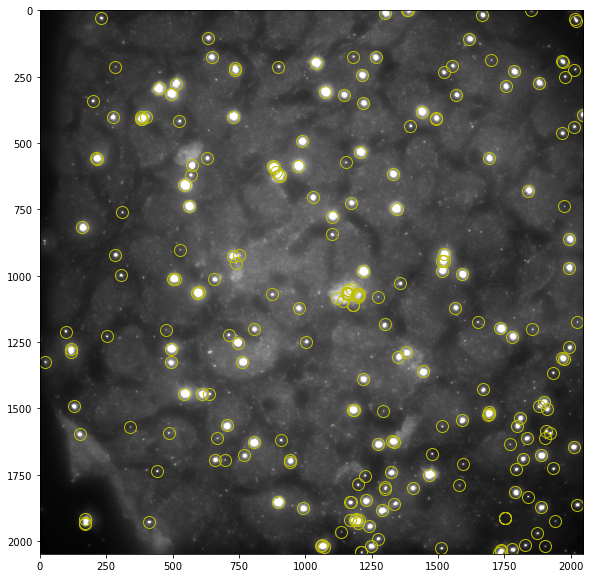

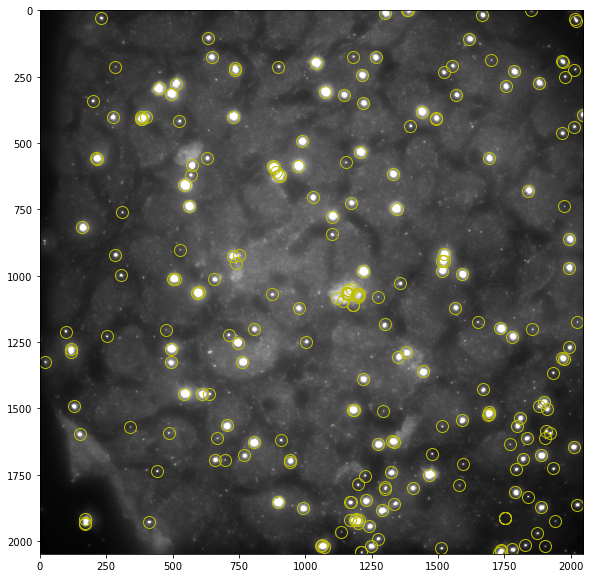

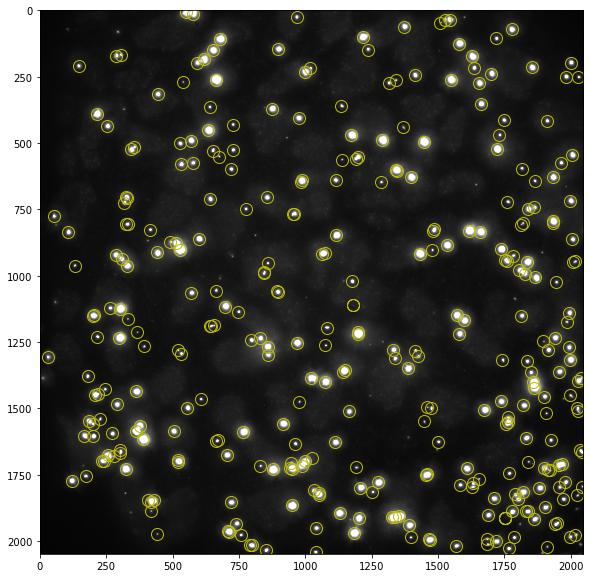

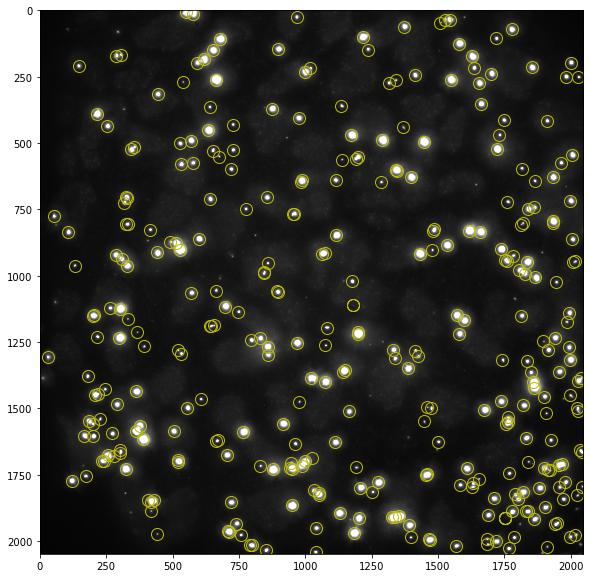

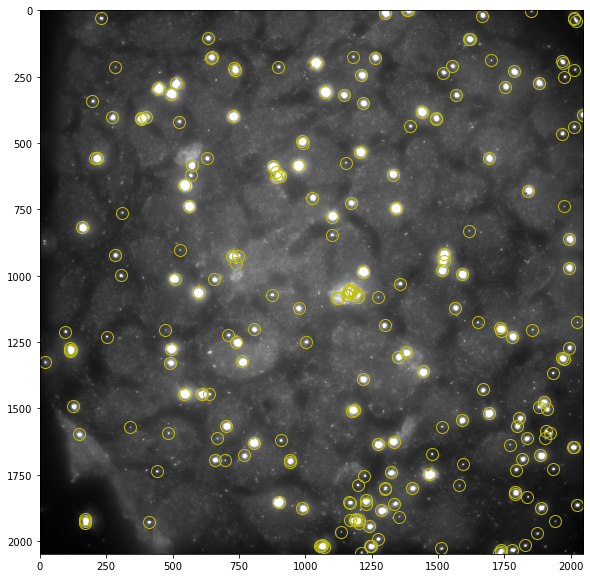

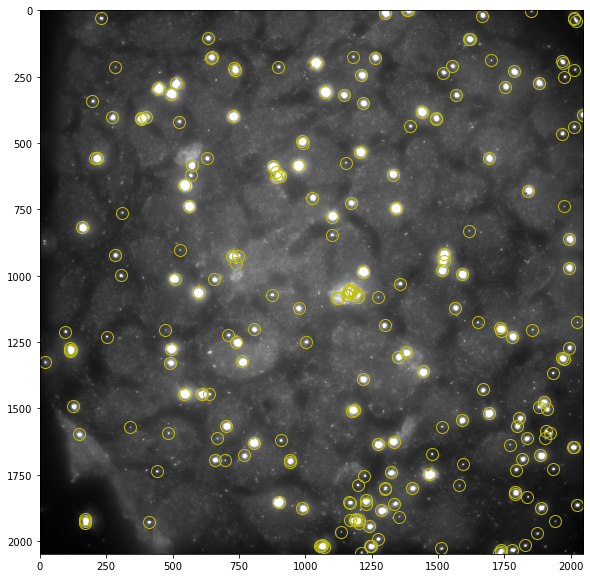

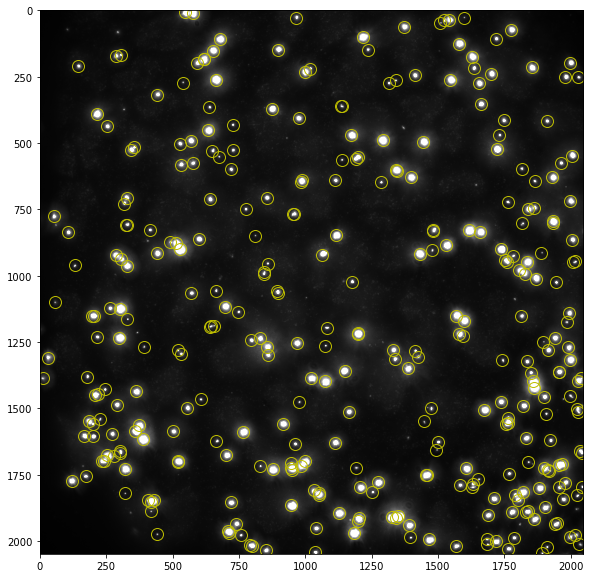

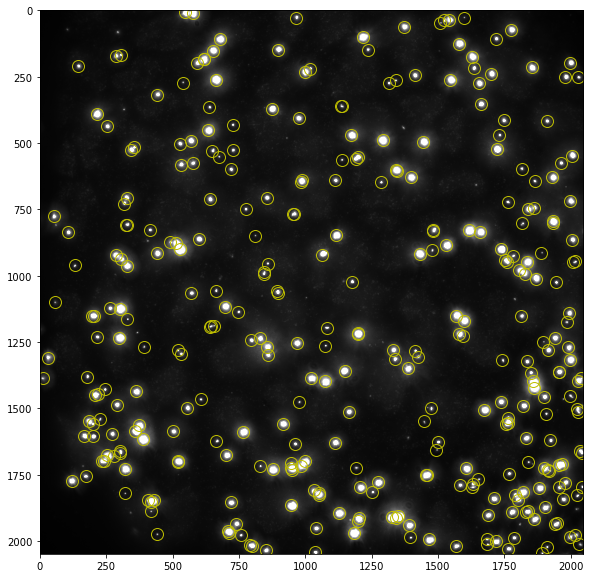

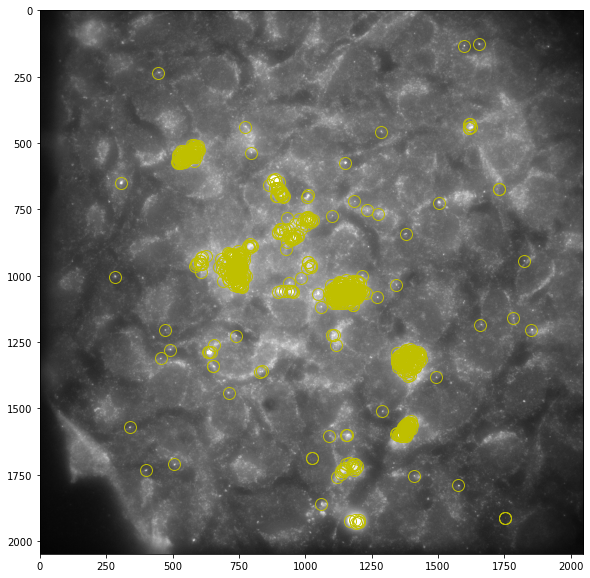

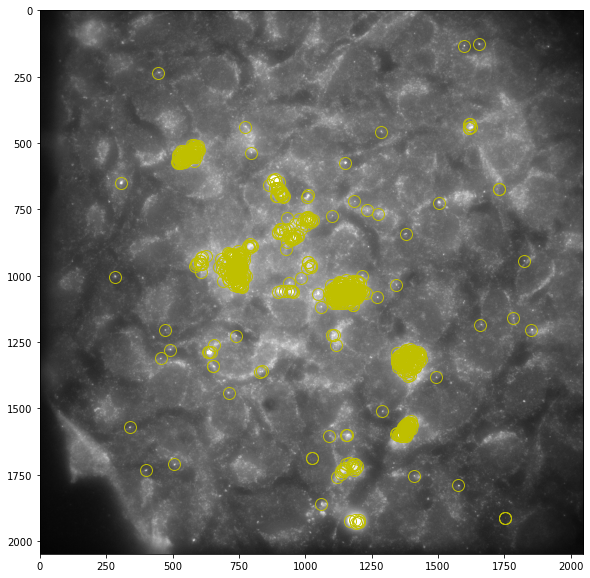

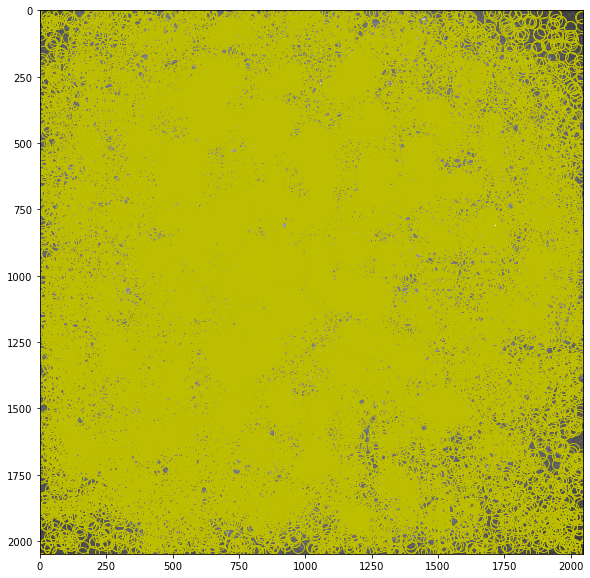

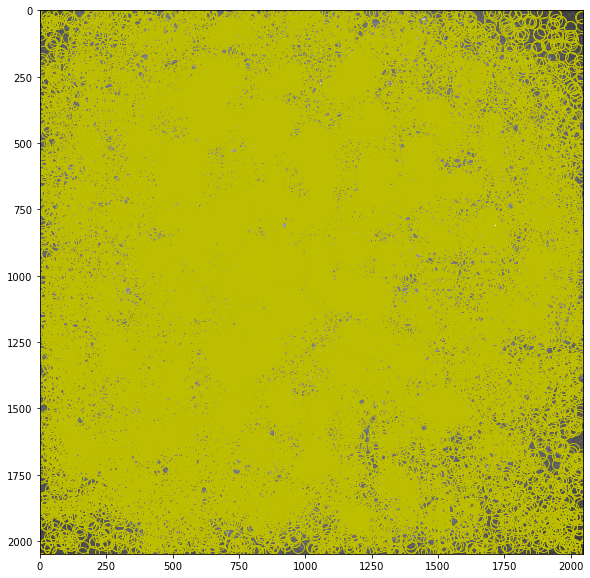

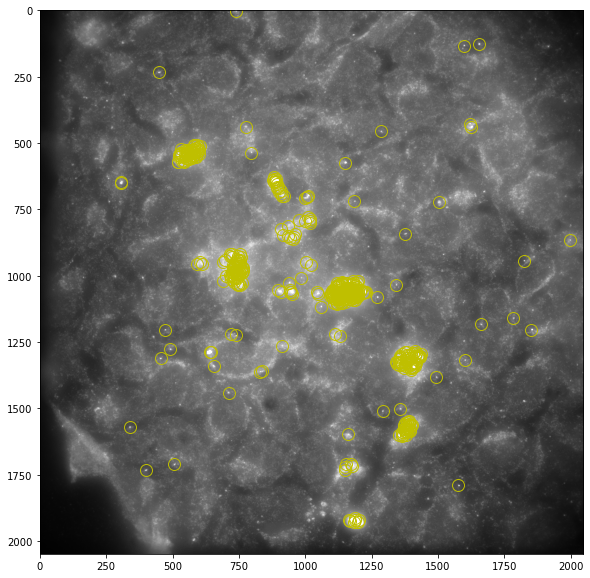

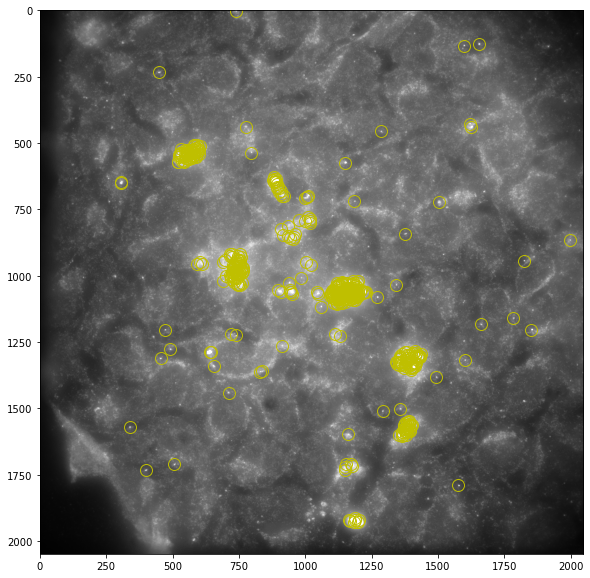

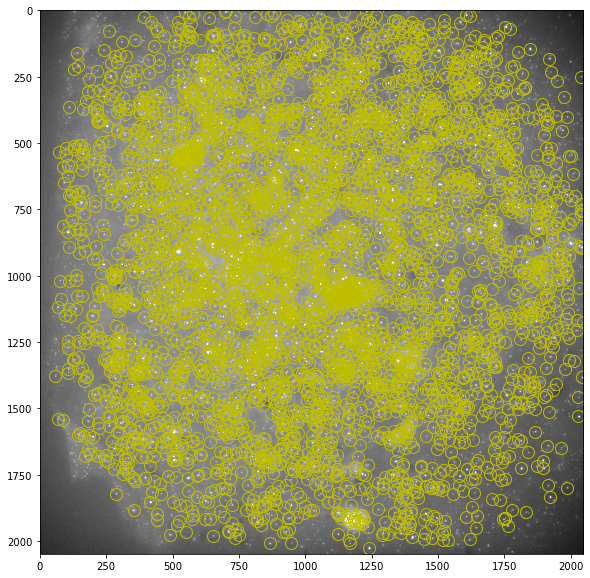

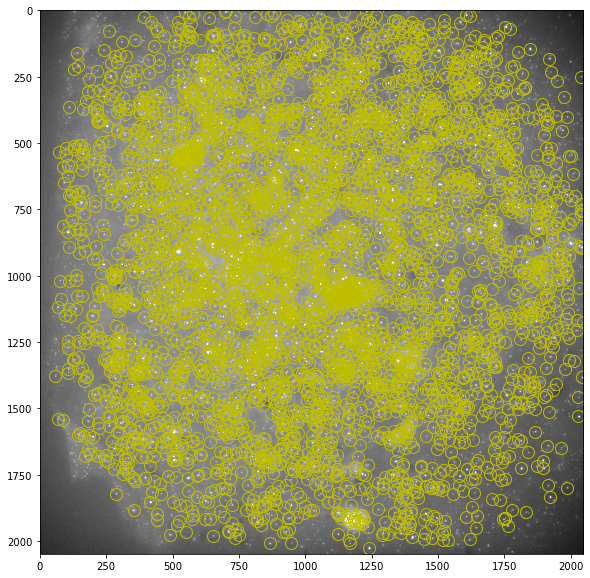

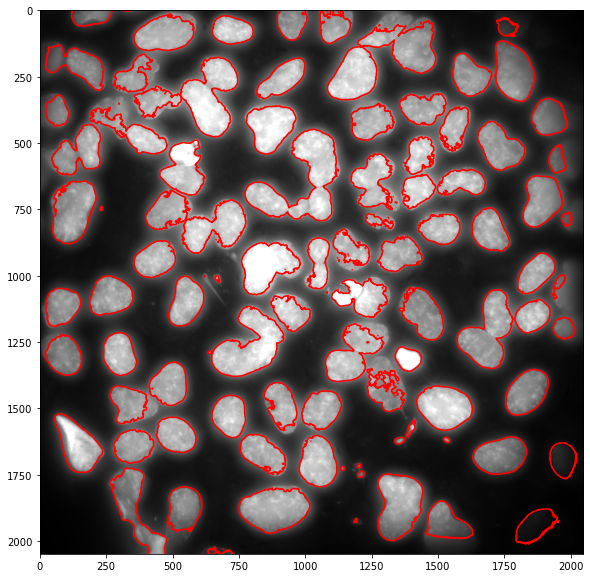

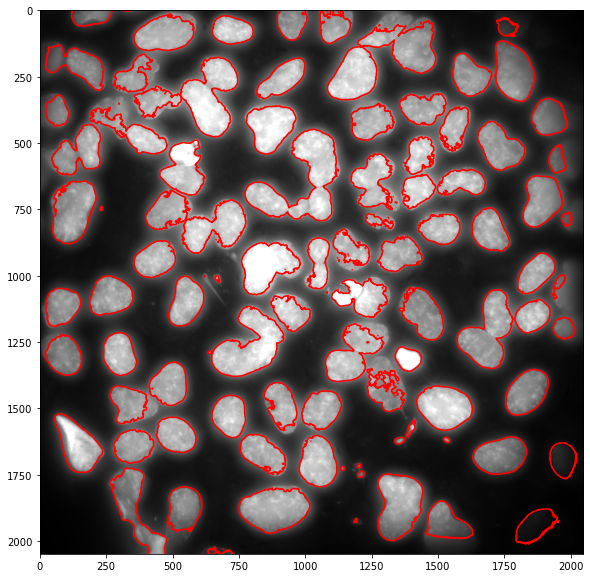

In [18]:
#Iterate trhough fovs - fit and drift correct

folder = r'D:\Data\wea_RCA_test'
analysis_folder = folder+os.sep+'Analysis'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
folders = glob.glob(folder+'\H*')
folders = [fld for fld in folders if len(glob.glob(fld+r'\*.tif')) and ('H2' in os.path.basename(fld))]
fovs = [os.path.basename(fl) for fl in glob.glob(folders[0]+r'\*.tif')]
cols = ['750','647','405']



#Iterate across FOVs
for fov in [fovs[2]]:
    #Load images into dictionary im_dic
    ims,ims_nms = [],[]
    for fld in tqdm(folders):
        fl = fld+os.sep+fov
        im = tifffile.imread(fl)
        ncols = len(cols)
        for icol,col in enumerate(cols):
            ims.append(im[icol::ncols])
            tag = os.path.basename(os.path.dirname(fl))+'_'+col
            ims_nms.append(tag)

    im_dic = {nm:im for im,nm in zip(ims,ims_nms)}

    #Fit and drift correct
    
    names = list(im_dic.keys())
    H_nocol = np.unique(['_'.join(e.split('_')[:-1]) for e in names])
    #cols = np.unique([e.split('_')[-1]for e in names])
    cols_bits = ['647', '750']
    col_bead = '405'
    dic_drift = {}
    dic_fits = {}
    dic_extra = {}
    #Load fitted data:
    #save_fl = save_base+'_final.pkl'
    #if os.path.exists(save_fl):
    #    dic_drift,dic_fits,dic_extra = pickle.load(open(save_fl,'rb'))
    

    save_base = analysis_folder+os.sep+fov.split('.')[0]
    for H in H_nocol:
        #perfor drift correction
        if H not in dic_drift:
            print("Drift correcting "+H+" on fov: "+fov)
            im1 = im_dic[H_nocol[0]+'_'+col_bead] # reference dapi image
            im2 = im_dic[H+'_'+col_bead] #current dapi image
            dic_drift[H]=series_align(im1,im2,s = 256,gb=30) #drift positions using fft
            
        #perform fitting
        for col in cols_bits:
            key = H+'_'+col
            
            if key not in dic_fits:
                print("Fitting "+H+'_'+col+" on fov: "+fov)
                im = im_dic[H+'_'+col] #current image
                std_ = np.std(im)
                hcut = np.median(im)+std_*5
                hmax = np.median(im)+std_*5 #keep 5 std above median - empirically this looked reasonable for the big spots.
                Xh = get_local_max(im,hcut,delta=3)
                dic_fits[H+'_'+col] = Xh


                #save diagnostic plots - image with fits on top
                fig = plt.figure(figsize=(10,10))
                plt.imshow(np.max(im,0),cmap='gray',vmax = hmax)
                plt.plot(Xh[:,2],Xh[:,1],'o',markersize=12,markeredgewidth=1,markeredgecolor='y',markerfacecolor='None')
                save_fig_ = save_base+'_'+H+'_'+col+'_fit.png'
                #fig.savefig(save_fig_)
                #plt.close('all')
    #get number of cells
    if not dic_extra:
        print("Estimating number of cells based on dapi image on fov: "+fov)
        H=H_nocol[0]
        im2 = im_dic[H+'_'+col_bead]
        im2_ = at.blurnorm2d(np.max(im2,0),300)
        im_dapi = im2_>1.25
        ncells,med_area = get_number_cells(im_dapi,min_area=5000,max_area=50000)
        dic_extra={'no_cells':ncells,'area_per_cell':med_area}

        save_fig_ = save_base+'_'+H+'_'+col+'_dapi.png'
        fig = plt.figure(figsize=(10,10))
        plt.imshow(np.max(im2,0),cmap='gray')
        plt.contour(im_dapi,[0.5],colors=['r'])
        #fig.savefig(save_fig_)
        #plt.close('all')

    #pickle.dump([dic_drift,dic_fits,dic_extra],open(save_fl,'wb'))

In [35]:
%matplotlib notebook

In [100]:
dic_drift[A[:-4]][0]

array([0., 0., 0.])

array([0., 0., 0.])

### Check the residual of the cleaving

In [120]:
#dic_fits['H2']

A,B = ['H2_750','H2_postCleave_750']
#A,B = ['H2_647','H2_postCleave_647']
z1,x1,y1,h1 =dic_fits[A].T
z2,x2,y2,h2 =dic_fits[B].T
from scipy.spatial.distance import cdist
X1 = np.array([z1,x1,y1]).T+dic_drift[A[:-4]][0]
X2 = np.array([z2,x2,y2]).T+dic_drift[B[:-4]][0]
M = cdist(X1,X2)
dists_ = np.min(M,axis=0)
i1 = np.argmin(M,axis=0)
i2 = np.arange(len(X2))
keep = dists_<5
i1_ = i1[keep]
i2_ = i2[keep]
np.median(X1[i1_]-X2[i2_],axis=0)
#plt.figure()
#plt.plot(x1[i1_],y1[i1_],'o')
#plt.plot(x2[i2_],y2[i2_],'x')
np.median(1./h1[i1_]*h2[i2_])

0.018920156948653274

0.018920156948653274

In [ ]:
## 2% cleaving residual

In [85]:
dic_fits.keys()

dict_keys(['H2_647', 'H2_750', 'H2_high_647', 'H2_high_750', 'H2_postCleave_647', 'H2_postCleave_750', 'H2_postCleave_high_647', 'H2_postCleave_high_750'])

dict_keys(['H2_647', 'H2_750', 'H2_high_647', 'H2_high_750', 'H2_postCleave_647', 'H2_postCleave_750', 'H2_postCleave_high_647', 'H2_postCleave_high_750'])

In [80]:
dic_drift['H2'][1]

[array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0

[array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0, 0]),
 array([0, 0

In [22]:
"""
H1_647 (1) = H3_750 (6)
H1_750 (2) = H4_647 (7)
H2_647 (4) = H6_647 (11) #H5_750 (9) N/A
H2_750 (3) = H5_647 (10) #H4_750 (8) N/A
H3_647 (5) =  H6_750 (12)
"""

'\nH1_647 (1) = H3_750 (6)\nH1_750 (2) = H4_647 (7)\nH2_647 (4) = H6_647 (11) #H5_750 (9) N/A\nH2_750 (3) = H5_647 (10) #H4_750 (8) N/A\nH3_647 (5) =  H6_750 (12)\n'

'\nH1_647 (1) = H3_750 (6)\nH1_750 (2) = H4_647 (7)\nH2_647 (4) = H6_647 (11) #H5_750 (9) N/A\nH2_750 (3) = H5_647 (10) #H4_750 (8) N/A\nH3_647 (5) =  H6_750 (12)\n'

<IPython.core.display.Javascript object>


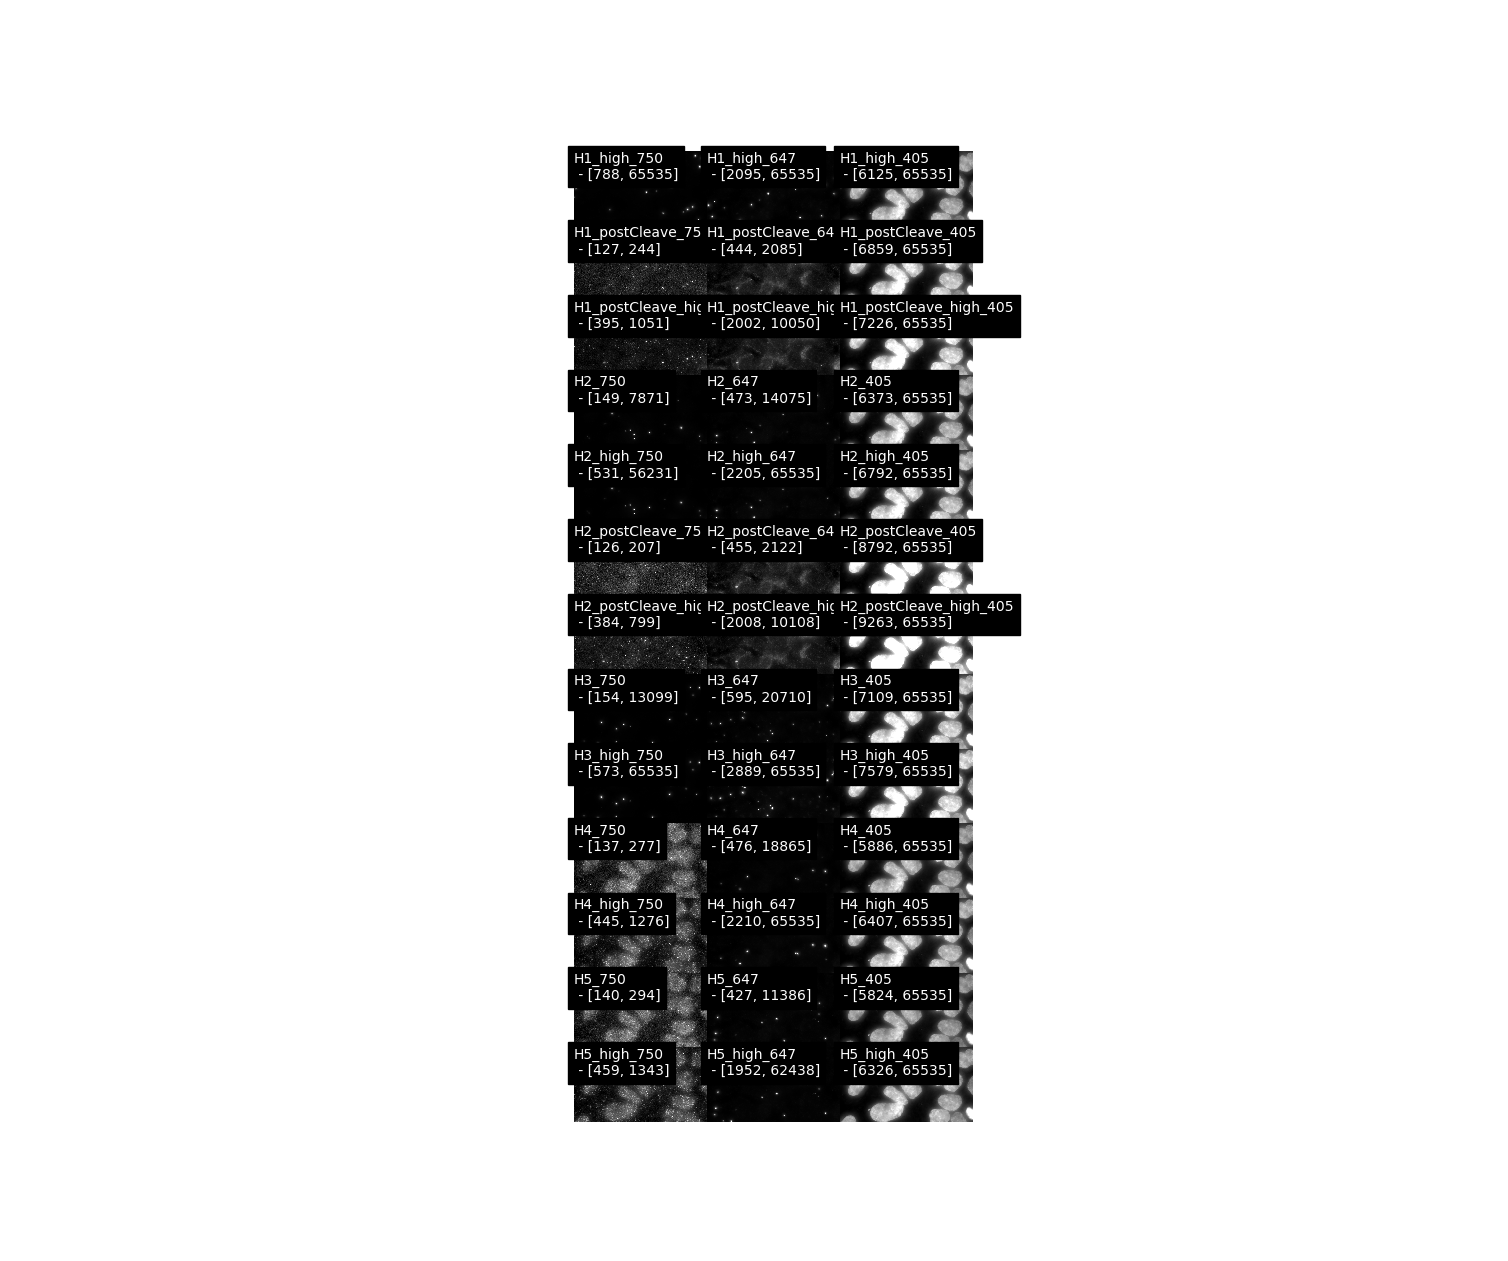

(-0.5, 2885.5, 7032.5, -0.5)

In [43]:
z_min,z_max,x_min,x_max,y_min,y_max =obj.get_limits()
ims_sm = [im_[z_min:z_max,x_min:x_max,y_min:y_max] for im_ in ims]

iimax = len(ims_sm)
col_row = 1.25
nrow = int(np.sqrt(iimax)/col_row)

nrow=3
ncol = int(np.ceil(iimax/float(nrow)))

nrow,ncol = ncol,nrow
ssz,ssx,ssy = ims_sm[0].shape
imf = np.zeros([ssx*nrow,ssy*ncol])
iim=0

def nm_to_R(nm_sm,cols = ['405','647','750']):
    return nm_sm

txts=[]
for irow in range(nrow):
    for icol in range(ncol):

        if iim<len(ims_sm):
            ims_sm_ = ims_sm[iim]
            nm_sm = ims_nms[iim]
            
            txt = nm_to_R(nm_sm)
            
            
            #if 'dapi' in txt: ims_sm_=[ims_sm_[int(len(ims_sm_)/2)]]
            
            im_plt,min_,max_ = mv.minmax(np.max(ims_sm_,0),percmax=99.95,pecmin=.5)
            imf[irow*ssx:(irow+1)*ssx,icol*ssy:(icol+1)*ssy]=im_plt
            txt+='\n - '+str([int(min_),int(max_)])
            txts.append([txt,irow*ssx,icol*ssy])
            iim+=1
            
import matplotlib.pylab as plt
fig = plt.figure(figsize=(12,7))
for txt,xtxt,ytxt in txts:
    plt.text(ytxt,xtxt,txt,color='white',backgroundcolor='k',horizontalalignment='left',verticalalignment='top',fontsize=10)
plt.imshow(imf,interpolation='nearest',cmap='gray')
plt.axis('off')